<a href="https://colab.research.google.com/github/naokishibuya/cuda-q-experiments/blob/main/notebooks/02_vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 — Hybrid Workflow (VQE)

This notebook demonstrates a **hybrid quantum–classical loop** in CUDA‑Q using a 2‑qubit VQE‑style example.

1. Define a simple **toy Hamiltonian**
2. Define a 2‑qubit **parameterized ansatz**
3. Build an **objective** with `cudaq.observe`
4. Optimize parameters with **SciPy** (fallback to a simple search if SciPy is unavailable)
5. Plot energy vs. iterations

See [01 — CUDA-Q Intro (Google Colab-ready)](01_cuda-q_intro.ipynb) for CUDA-Q setup.

In [1]:
# Uncomment and install cuda-q if not already

# %pip install --upgrade pip
# %pip install cudaq

## Define a 2‑Qubit Hamiltonian

Our Hamiltonian is:
$$ H = Z_0 Z_1 + X_0 + X_0. $$

This is a toy example with the following characteristics:
- $Z_0 Z_1$: This term represents an interaction between the two qubits (qubit 0 and qubit 1). The Pauli-Z operator ($Z$) measures the state of a qubit in the computational basis ($|0\rangle$ and $|1\rangle$). The product $Z_0 Z_1$ means we are taking the product of the Z measurements on both qubits. If both qubits are in the same state ($|00\rangle$ or $|11\rangle$), the contribution from this term is positive. If they are in different states ($|01\rangle$ or $|10\rangle$), the contribution is negative. This term is often used to represent interactions between qubits, such as Ising-type interactions.
- $X_0$, $X_1$: These terms represent local effects on qubit 0 and 1. The Pauli-X operator ($X$) is the quantum NOT gate. Measuring in the X basis is equivalent to measuring in the computational basis after applying a Hadamard gate. This term can represent a magnetic field or other local potential acting on qubit 0 and 1.

So, the total Hamiltonian $H$ is a sum of these two terms. It's a 2-qubit Ising model with a transverse field on both qubits, and describes the total energy of the system.

In [2]:
import cudaq

# Hamiltonian H = Z0*Z1 + X0 + X1
H = cudaq.spin.z(0) * cudaq.spin.z(1) + cudaq.spin.x(0) + cudaq.spin.x(1)

print(str(H))

(1+0i) * Z0Z1 + (1+0i) * X0 + (1+0i) * X1


We use an ansatz with four parameters $\alpha, \beta, \gamma, \delta$:

$$
|\psi(\alpha,\beta,\gamma,\delta)\rangle = \bigl[\mathrm{RY}_0(\alpha) \otimes \mathrm{RY}_1(\beta) \bigr] \;\mathrm{CNOT}_{0\to1}\; \bigl[\mathrm{RY}_0(\gamma) \otimes \mathrm{RY}_1(\delta) \bigr]\,|00\rangle
$$


In [3]:
from math import pi

# Parameterized kernel: four parameters.
def make_kernel():
    kernel, *params = cudaq.make_kernel(float, float, float, float)
    q = kernel.qalloc(2)

    kernel.ry(params[0], q[0])
    kernel.ry(params[1], q[1])
    kernel.cx(q[0], q[1])
    kernel.ry(params[2], q[0])
    kernel.ry(params[3], q[1])
    return kernel, q

kernel, _ = make_kernel()

print("MLIR:")
print(kernel)

MLIR:
module attributes {quake.mangled_name_map = {__nvqpp__mlirgen____nvqppBuilderKernel_7641EJHL82 = "__nvqpp__mlirgen____nvqppBuilderKernel_7641EJHL82_PyKernelEntryPointRewrite"}} {
  func.func @__nvqpp__mlirgen____nvqppBuilderKernel_7641EJHL82(%arg0: f64, %arg1: f64, %arg2: f64, %arg3: f64) attributes {"cudaq-entrypoint", "cudaq-kernel"} {
    %0 = quake.alloca !quake.veq<2>
    %1 = quake.extract_ref %0[0] : (!quake.veq<2>) -> !quake.ref
    quake.ry (%arg0) %1 : (f64, !quake.ref) -> ()
    %2 = quake.extract_ref %0[1] : (!quake.veq<2>) -> !quake.ref
    quake.ry (%arg1) %2 : (f64, !quake.ref) -> ()
    quake.x [%1] %2 : (!quake.ref, !quake.ref) -> ()
    quake.ry (%arg2) %1 : (f64, !quake.ref) -> ()
    quake.ry (%arg3) %2 : (f64, !quake.ref) -> ()
    return
  }
}



In [4]:
# A circuit with a list of parameters given
print(cudaq.draw(kernel, 0.0, 0.0, 0.0, 0.0))

     ╭───────╮     ╭───────╮
q0 : ┤ ry(0) ├──●──┤ ry(0) ├
     ├───────┤╭─┴─╮├───────┤
q1 : ┤ ry(0) ├┤ x ├┤ ry(0) ├
     ╰───────╯╰───╯╰───────╯



In [5]:
# Another example with different parameter values
print(cudaq.draw(kernel, 0.1, 0.2, 0.3, 0.4))

     ╭─────────╮     ╭─────────╮
q0 : ┤ ry(0.1) ├──●──┤ ry(0.3) ├
     ├─────────┤╭─┴─╮├─────────┤
q1 : ┤ ry(0.2) ├┤ x ├┤ ry(0.4) ├
     ╰─────────╯╰───╯╰─────────╯



The goal of the VQE algorithm is to find the parameters for the ansatz circuit that minimize the expectation value of this Hamiltonian, which corresponds to finding an approximation of the ground state energy of the system.

The Hamiltonian can be calculated as follows, using computational basis $\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$.

$$
Z_0Z_1 = \text{diag}(+1, -1, -1, +1)
$$

$$
X_0 = X_0 I_1 = \begin{bmatrix}
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0
\end{bmatrix}
$$

$$
X_1 = I_0 X_1 = \begin{bmatrix}
  0 & 1 & 0 & 0 \\
  1 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 \\
  0 & 0 & 1 & 0
\end{bmatrix}
$$

So, the Hamiltonian is:

$$
H = Z_0Z_1 + X_0 + X_1 = \begin{bmatrix}
1 &  1 &  1 & 0 \\
1 & -1 &  0 & 1 \\
1 &  0 & -1 & 1 \\
0 &  1 &  1 & 1
\end{bmatrix}
$$

The theoretical minimum of the Hamiltonian can be estimated as follows:

In [6]:
import numpy as np

# Matrix representation of the Hamiltonian H = Z0*Z1 + X0 + X1
H_matrix = np.array([
    [1,  1,  1, 0],
    [1, -1,  0, 1],
    [1,  0, -1, 1],
    [0,  1,  1, 1]
])

# Calculate the eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(H_matrix)

print("Eigenvalues of the Hamiltonian:")
print(eigenvalues)

print("\nEigenvectors of the Hamiltonian:")
print(eigenvectors)

# The ground state energy is the minimum eigenvalue
min_index = np.argmin(eigenvalues)
ground_energy = eigenvalues[min_index]
ground_state  = eigenvectors[:, min_index]

print(f"\nGround state energy (minimum eigenvalue): {ground_energy}")
print(ground_state)

Eigenvalues of the Hamiltonian:
[ 2.23606798  1.         -2.23606798 -1.        ]

Eigenvectors of the Hamiltonian:
[[-6.01500955e-01 -7.07106781e-01 -3.71748034e-01  1.11022302e-16]
 [-3.71748034e-01 -8.53785880e-17  6.01500955e-01 -7.07106781e-01]
 [-3.71748034e-01  2.48198220e-17  6.01500955e-01  7.07106781e-01]
 [-6.01500955e-01  7.07106781e-01 -3.71748034e-01  1.11022302e-16]]

Ground state energy (minimum eigenvalue): -2.2360679774997902
[-0.37174803  0.60150096  0.60150096 -0.37174803]


## Objective Function with `observe`
We compute the expectation value $E(\text{params}) = \langle H \rangle$ **without** destructive measurement.


In [7]:
from math import sqrt

def energy(*params) -> float:
    """Return the expectation <H> for given parameters."""
    obs = cudaq.observe(kernel, H, *params)
    return obs.expectation()

# Quick smoke tests
for params in [
  [0.0, 0.0, 0.0, 0.0],   # No RY, CNOT has no effect: |00> => |00>
  [pi , 0.0, 0.0, 0.0],   # RY(pi) on 0 and CNOT triggers: |00> => |11>
  [pi , 0.0, 0.0, pi ],   # RY(pi) on 0 and CNOT triggers and RY(pi) on 1: |00> => |10>
]:
    print(f"E({params}) = {energy(*params)}")


E([0.0, 0.0, 0.0, 0.0]) = 1.0
E([3.141592653589793, 0.0, 0.0, 0.0]) = 1.000000000000002
E([3.141592653589793, 0.0, 0.0, 3.141592653589793]) = -0.9999999125772234


## Optimize with SciPy

The goal of the VQE algorithm: to find the parameters for the ansatz circuit that minimize the expectation value of the Hamiltonian.

Note: the state that minimizes this expectation value <H> is an approximation of the ground state of the Hamiltonian.


In [8]:
import math
import numpy as np
import scipy.optimize as opt

history = []  # plotting later

# minimization objective
def objective(x):
    e = energy(*x)
    history.append(e)
    return e


# initial guess
x0 = [0, 0, 0, 0]

# minimization
res = opt.minimize(
    objective,
    x0=x0,
    method='Nelder-Mead',
    options={
        'maxiter': 1000,
        'disp': True,
    },
)

if res.success:
    optimal_x = res.x
    optimal_e = energy(*optimal_x)

    print('\nOptimized parameters (theta, phi):', optimal_x)
    print('Min energy ~', optimal_e)
else:
    print('\nOptimization failed!')

Optimization terminated successfully.
         Current function value: -2.236068
         Iterations: 235
         Function evaluations: 405

Optimized parameters (theta, phi): [ 1.64157334 -2.03583877  0.07909229 -0.03510453]
Min energy ~ -2.236068218946457


## Plot Energy vs Iterations
Matplotlib only, one figure, no style overrides.


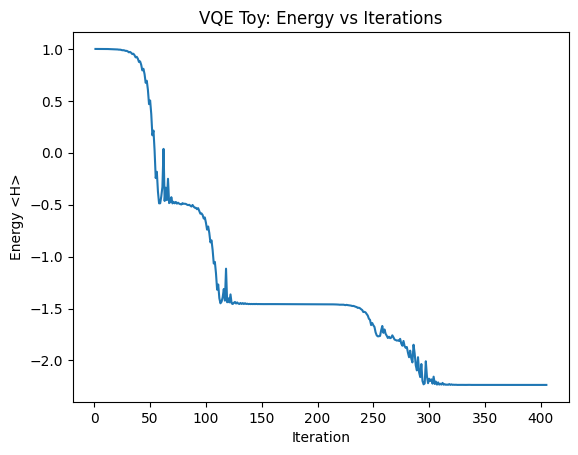

In [9]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(history, dtype=float)
x = np.arange(1, len(y) + 1)

plt.figure()
plt.plot(x, y)
plt.xlabel('Iteration')
plt.ylabel('Energy <H>')
plt.title('VQE Toy: Energy vs Iterations')
plt.show()


### Sample Bitstrings at the Optimum
Sampling collapses the state; this is just to inspect the distribution at the optimum.


In [10]:
shots = cudaq.sample(kernel, *optimal_x, shots_count=2000)

print(shots)

{ 00:262 01:717 10:744 11:277 }



The ground state is mostly anti-correlated in Z (more weight on 01 and 10 than 00 and 11), as the sample distribution shows.

From these samples measured in the computational ($Z$) basis, we can estimate

$$
\langle Z_0 Z_1\rangle = P_{00}+P_{11}-P_{01}-P_{10}
= \tfrac{268+276-702-754}{2000} \approx -0.456.
$$

For the true ground state of $H=Z_0Z_1+X_0+X_1$,

$$
\langle Z_0 Z_1\rangle = -\tfrac{1}{\sqrt{5}}\approx -0.4472,\quad
\langle X_0\rangle=\langle X_1\rangle=-\tfrac{2}{\sqrt{5}}\approx -0.8944.
$$

The sampled $\langle Z_0Z_1\rangle\approx -0.456$ is **very close** to the theoretical $-0.4472$, which is exactly what we expect.

We can also measure in the $X$ basis as follows:

In [11]:
k, q = make_kernel()

# Measure in X basis means apply Hadamard and measure in Z (the computational basis is default).
k.h(q[0])
k.h(q[1])

shots = cudaq.sample(k, *optimal_x, shots_count=2000)

print(shots)

{ 00:92 11:1908 }



The bitstrings mean:

- $00 \to X_0 = +1, X_1 = +1$
- $11 \to X_0 = -1, X_1 = -1$

They are perfectly correlated (they flip together).

The probabilities are:

- $P(00) \approx 0.054$
- $P(11) \approx 0.946$.

The expectation values are:

$$
\langle X_0 \rangle = \langle X_1 \rangle = 0.054 \times +1 + 0.946 \times -1 \approx -0.892
$$

This closely matches with the theoretical ground state prediction ($\approx -0.8944$).
